In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
%matplotlib inline

from __future__ import division

#### Stock Name and Source

For more information on available sources:
http://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [195]:
stock = 'AAPL'
source = 'yahoo'

#### Set start and end date

In [196]:
end = datetime.datetime.today()
start = datetime.datetime(2000,1,1)

In [197]:
f = web.DataReader(stock, source, start, end)

# Let's clear NaN rows
f = f.dropna()

# Data Preview

In [198]:
f.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,3.604911,3.674107,3.553571,3.671875,3.291592,40952800
2000-01-03,3.745536,4.017857,3.631696,3.997768,3.583733,133949200
2000-01-04,3.866071,3.950893,3.613839,3.660714,3.281587,128094400
2000-01-05,3.705357,3.948661,3.678571,3.714286,3.329610,194580400
2000-01-06,3.790179,3.821429,3.392857,3.392857,3.041471,191993200


# Pre-processing

### Get daily returns

In [199]:
daily_ret = f.copy()

In [200]:
daily_ret['Close Pct Change'] = f.Close.pct_change()
daily_ret['Adj Close Pct Change'] = f['Adj Close'].pct_change()

In [201]:
daily_ret.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [202]:
daily_ret.dropna(axis = 0, how='any', inplace=True)
daily_ret.head()

,Close Pct Change,Adj Close Pct Change
Date,,
2000-01-03,0.088754,0.088754
2000-01-04,-0.084311,-0.084310
2000-01-05,0.014634,0.014634
2000-01-06,-0.086539,-0.086538
2000-01-07,0.047368,0.047368


# General Statistics

In [203]:
daily_ret.describe()

,Close Pct Change,Adj Close Pct Change
count,4499.000000,4499.000000
mean,0.001216,0.001240
std,0.026243,0.026239
min,-0.518692,-0.518692
25%,-0.010884,-0.010848
50%,0.000775,0.000865
75%,0.013356,0.013356
max,0.139050,0.139050


In [204]:
daily_ret['Close Pct Change'].autocorr(lag=1)

-0.033252326421079802

# Rolling Statistics

In [205]:
rolling = daily_ret.copy()

### Rolling Means 30 Period

In [206]:
rolling['Rolling Mean 30 Periods'] = rolling['Close Pct Change'].rolling(30).mean()

In [207]:
rolling['Rolling Mean 30 Periods'].describe()

count    4470.000000
mean        0.001205
std         0.004791
min        -0.031093
25%        -0.001079
50%         0.001539
75%         0.003983
max         0.016542
Name: Rolling Mean 30 Periods, dtype: float64

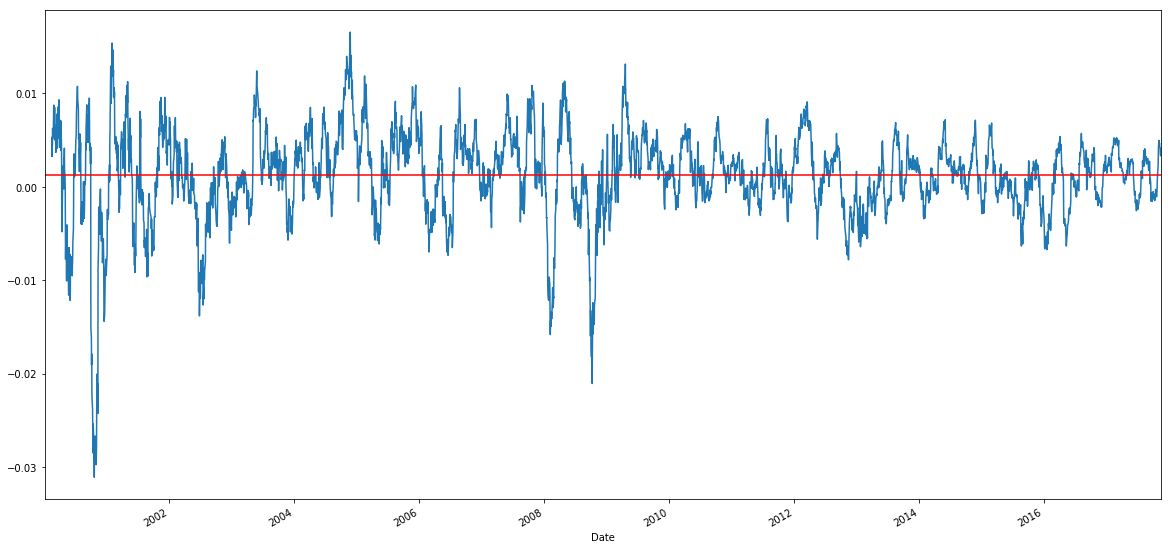

In [208]:
rolling['Rolling Mean 30 Periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].mean(), color='r')

### Rolling STDEV 30 periods

In [209]:
rolling['Rolling STD 30 Periods'] = rolling['Close Pct Change'].rolling(30).std()

In [210]:
rolling['Rolling STD 30 Periods'].describe()

count    4470.000000
mean        0.023025
std         0.012305
min         0.005085
25%         0.014552
50%         0.020204
75%         0.028317
max         0.107681
Name: Rolling STD 30 Periods, dtype: float64

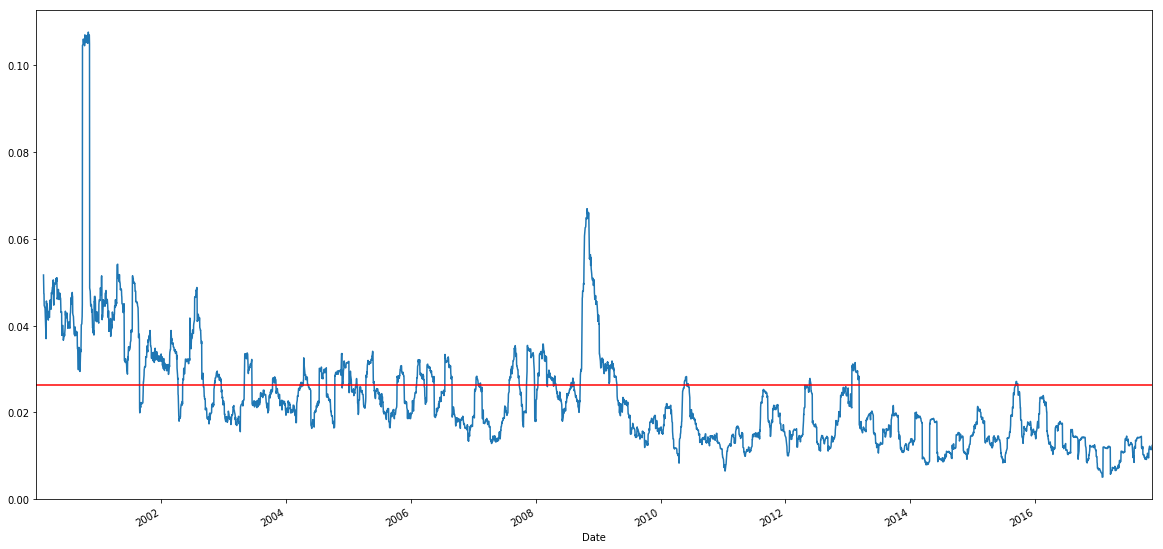

In [211]:
rolling['Rolling STD 30 Periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].std(), color='r')

### Rolling Auto-Correlation (Lag = 1) 30 periods

In [212]:
rolling['Rolling AutoCorr 30 periods'] = rolling['Close Pct Change'].rolling(
    center=False,window=30).apply(func=lambda x: pd.Series(x).autocorr(1))

In [213]:
rolling['Rolling AutoCorr 30 periods'].describe()

count    4470.000000
mean       -0.033179
std         0.162471
min        -0.618893
25%        -0.140206
50%        -0.034592
75%         0.061035
max         0.528201
Name: Rolling AutoCorr 30 periods, dtype: float64

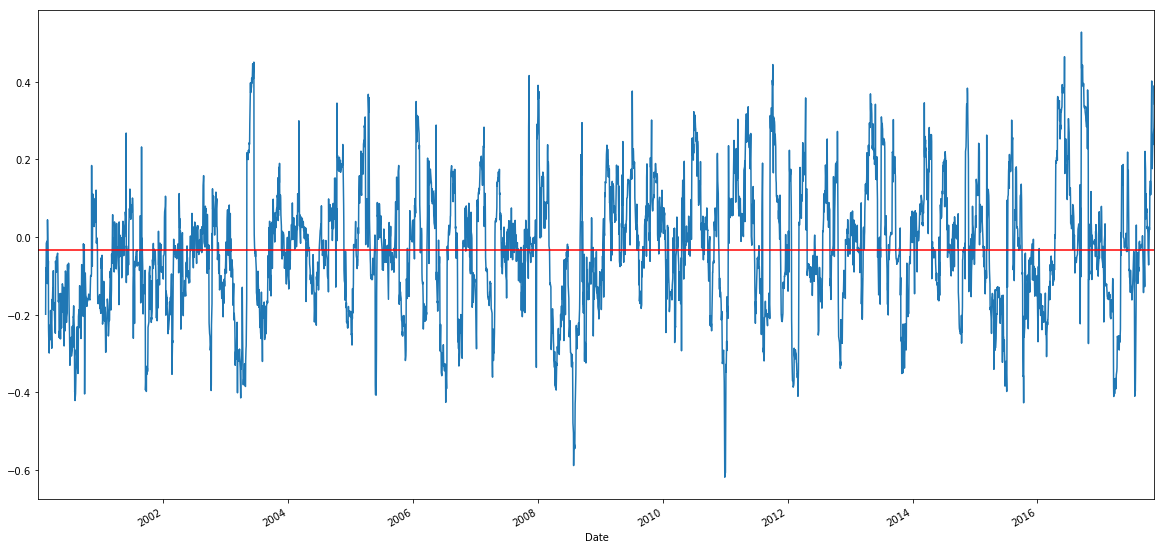

In [214]:
rolling['Rolling AutoCorr 30 periods'].plot(figsize=(20,10))
plt.axhline(rolling['Close Pct Change'].autocorr(1), color='r')

# Simple Monte Carlo

In [215]:
start_price = f.tail(1).Close[0]
days = 250
mu = rolling['Close Pct Change'].mean()
sigma = rolling['Close Pct Change'].std()

def stock_monte_carlo(args):
    # args: start_price, days, mu, sigma
    days = args[1]
    dt = 1/days
    price = np.zeros(days)
    price[0] = args[0]
    ret = np.zeros(days)
    mu = args[2]
    sigma = args[3]
    
    for x in xrange(1, days):
        ret[x] = np.random.normal(loc=mu, scale=sigma)
        price[x] = price[x-1]+(price[x-1]*ret[x])
    return price

In [216]:
def run_monte_carlo(*args):
    plt.figure(figsize=(20,10))
    for run in xrange(100):
        plt.plot(args[0](args[1:]))
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title('Monte Carlo Analysis')

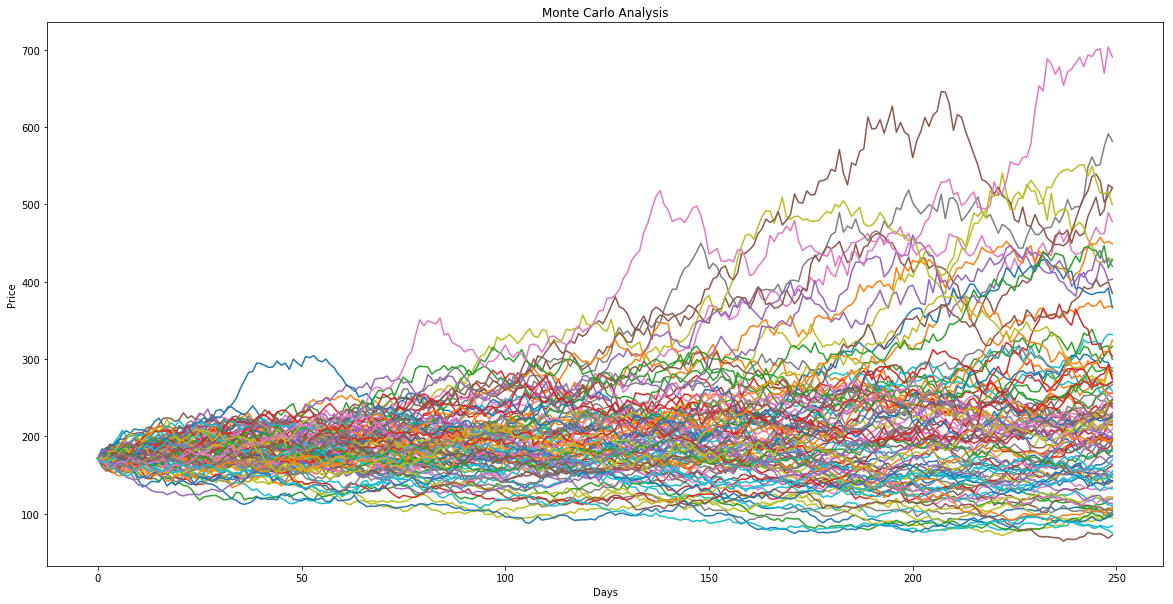

In [228]:
run_monte_carlo(stock_monte_carlo, start_price,days,mu,sigma)

In [218]:
def run_VaR_monte_carlo(*args):
    runs = 10000

    simulations = np.zeros(runs)

    for run in xrange(runs):
        simulations[run] = args[0](args[1:])[args[2]-1]
        
    q = np.percentile(simulations, 1)
    plt.figure(figsize=(20,10))
    plt.hist(simulations, bins=200)
    plt.figtext(0.6, 0.8, s='Start price: $%.2f' % start_price)
    plt.figtext(0.6,0.7,'Mean final price: $%.2f' % simulations.mean())
    plt.figtext(0.6,0.6,'Var(0.99): $%.2f' % (start_price - q))
    plt.figtext(0.15,0.6,'q(0.99): $%.2f' % q)
    plt.axvline(x=q, linewidth=4, color='r')
    plt.title(u'Final price distribution after %s days' % days, weight='bold')
    
    return simulations

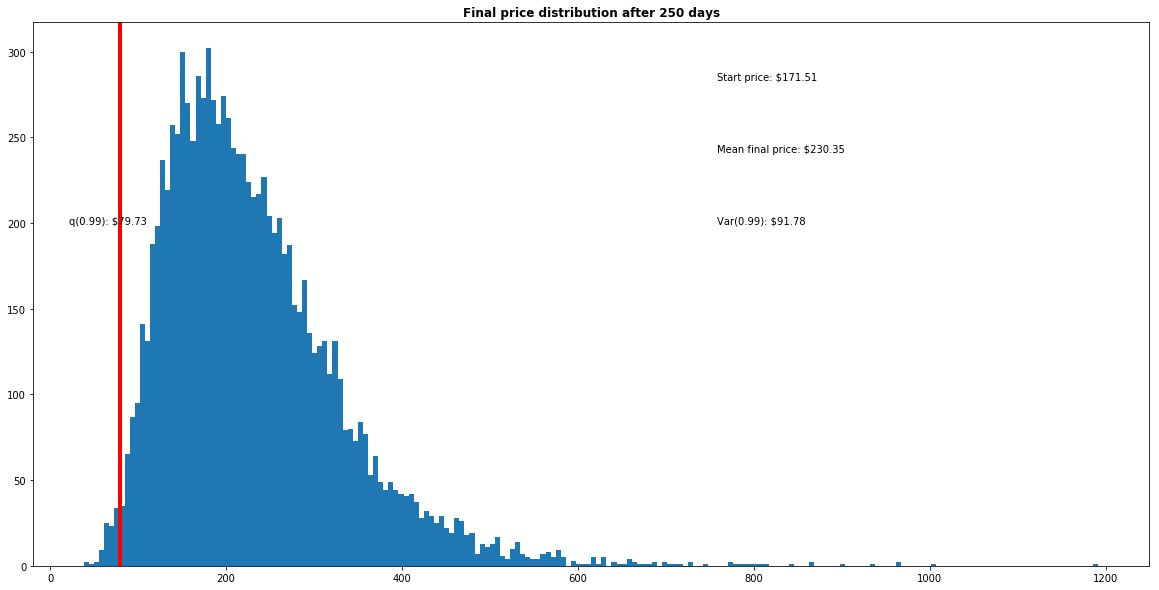

In [229]:
simulations = run_VaR_monte_carlo(stock_monte_carlo, start_price, days, mu, sigma)

In [220]:
pd.DataFrame(simulations).describe()

,0
count,10000.000000
mean,232.771217
std,99.270689
min,43.286961
25%,163.099821
50%,213.835916
75%,281.734987
max,1202.263533


# Non-stationary Monte Carlo Simulation (Independent for each t)

In [221]:
def nonStationaryMonteCarlo(args):
    # args: start_price, days, mu_drift, mu_shock, sigma_drift, sigma_shock
    days = args[1]
    dt = 1/days
    price = np.zeros(days)
    price[0] = args[0]
    ret = np.zeros(days)
    
    mu_drift = args[2]
    mu_shock = args[3]
    sigma_drift = args[4]
    sigma_shock = args[5]

    
    for x in xrange(1, days):
        mu = np.random.normal(loc=mu_drift, scale=mu_shock)
        sigma = abs(np.random.normal(loc=sigma_drift, scale=sigma_shock))
    
        ret[x] = np.random.normal(loc=mu, scale=sigma)
        price[x] = price[x-1]+(price[x-1]*ret[x])
    
    return price

In [222]:
start_price = f.tail(1).Close[0]
days = 250
mu_drift = ret_roc['Rolling Mean 30 Periods'].mean()
mu_shock = ret_roc['Rolling Mean 30 Periods'].std()

sigma_drift = ret_roc['Rolling STD 30 Periods'].mean()
sigma_shock = ret_roc['Rolling STD 30 Periods'].std()

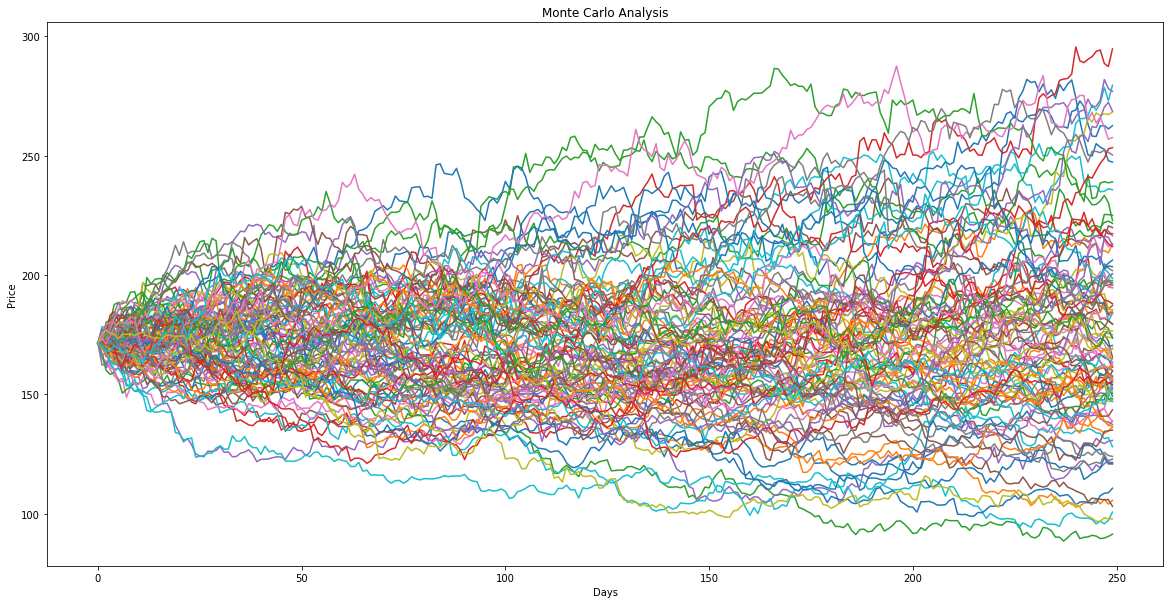

In [226]:
run_monte_carlo(nonStationaryMonteCarlo, start_price, days, mu_drift, mu_shock, sigma_drift, sigma_shock)

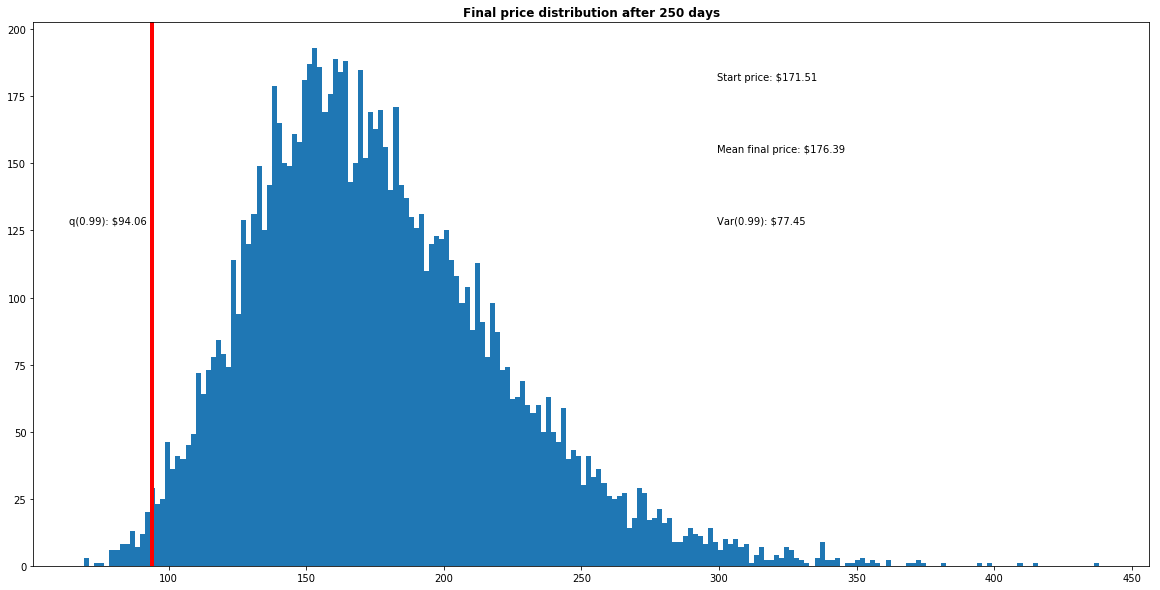

In [227]:
simulations = run_VaR_monte_carlo(nonStationaryMonteCarlo, start_price, days, mu_drift, mu_shock, sigma_drift, sigma_shock)

In [225]:
pd.DataFrame(simulations).describe()

,0
count,10000.000000
mean,176.150837
std,45.133269
min,65.699847
25%,143.752036
50%,170.598565
75%,201.717003
max,486.238880
